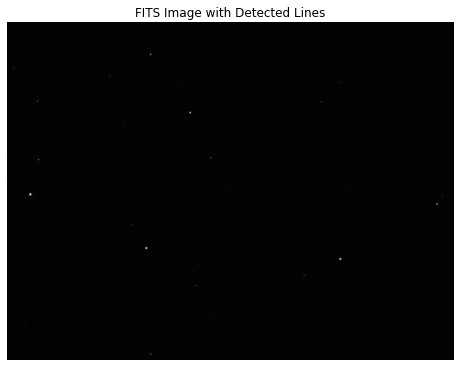

File: ./Data/fits/tic1.fit, Number of Lines Detected: 1


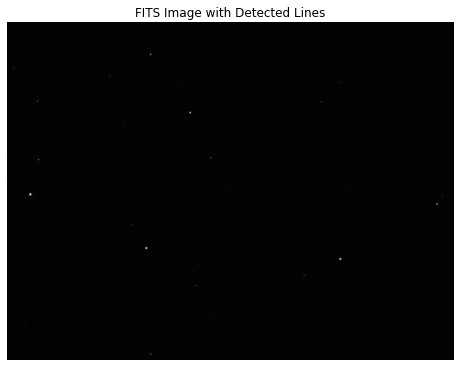

File: ./Data/fits/tic1.fit, Number of Lines Detected: 1
File: ./Data/fits/tic11.fit, Number of Lines Detected: 1
File: ./Data/fits/tic12.fit, Number of Lines Detected: 1
File: ./Data/fits/tic13.fit, Number of Lines Detected: 1
File: ./Data/fits/tic14.fit, Number of Lines Detected: 1
File: ./Data/fits/tic15.fit, Number of Lines Detected: 1
File: ./Data/fits/tic16.fit, Number of Lines Detected: 1
File: ./Data/fits/tic17.fit, Number of Lines Detected: 1


In [1]:
import os
import torch
from torchvision.transforms import transforms
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


fits_folder = './Data/fits/'


def determine_label(image_data, threshold=100):
    # Compute the average pixel intensity in the image
    average_intensity = np.mean(image_data)
    # Classify the image based on the threshold
    if average_intensity > threshold:
        return 1  # Image contains lines
    else:
        return 0  # Image does not contain lines

file_labels = []
fits_files = [os.path.join(fits_folder, file) for file in os.listdir(fits_folder) if file.endswith('.fit') and 'tic' in file]


# Populate the file_labels list
for file_path in fits_files:
    hdul = fits.open(file_path)
    image_data = hdul[0].data.astype(np.float32)
    hdul.close()
    label = determine_label(image_data)
    file_labels.append((file_path, label))

# Define a custom dataset class
class FITSDataset(torch.utils.data.Dataset):
    def __init__(self, file_labels, transform=None):
        self.file_labels = file_labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_labels)
    
    def __getitem__(self, idx):
        file_path, label = self.file_labels[idx]
        hdul = fits.open(file_path)
        image_data = hdul[0].data.astype(np.float32)
        hdul.close()
        if self.transform:
            image_data = self.transform(image_data)
        return image_data, label


# Define transforms to preprocess the image
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()) * 255),  # Scale to 0-255
    transforms.Lambda(lambda x: torch.cat([x] * 3, dim=0)),  # Convert single channel to three channels
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),  # Resize to match Inception input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485] * 3, std=[0.229] * 3)  # Normalize
])

# Create datasets and dataloaders
fits_dataset = FITSDataset(file_labels, transform=transform)
fits_loader = DataLoader(fits_dataset, batch_size=32, shuffle=False)  


n=0
for file_path, label in file_labels:
    n=n+1
    if n<3:
        file_path, label = file_labels[0]

        hdul = fits.open(file_path)
        image_data = hdul[0].data.astype(np.float32)
        hdul.close()

        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image_data, cmap='gray')
        plt.title('FITS Image with Detected Lines')
        plt.axis('off')

        plt.show()

    if n<10:
        print(f"File: {file_path}, Number of Lines Detected: {label}")
